In [1]:
# Importing required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
# from fbprophet import Prophet
# import warnings
# warnings.filterwarnings('ignore')
from sqlalchemy import create_engine
from unicodedata import normalize

In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
#  Import and read the charity_data.csv.
# import pandas as pd 
# application_df = pd.read_csv("Resources/charity_data.csv")
# application_df.head()
train_df = pd.read_csv('/gdrive/MyDrive/project4/Tanner/Resources/grocery_train.csv')
train_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [4]:
len(train_df)

3000888

In [5]:
# check data types for SQL compatibility 
train_df.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

In [6]:
# convert 'date' column to datetime format for merging with other CSV's 
train_df['date'] = pd.to_datetime(train_df['date'])
train_df.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [7]:
# read in the holiday data file 
# holiday_file = "resources/holidays_events.csv"
# holiday_df = pd.read_csv(holiday_file)
# holiday_df.tail()

holiday_df = pd.read_csv('/gdrive/MyDrive/project4/Tanner/Resources/holiday.csv')
holiday_df

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [8]:
len(holiday_df)

350

In [9]:
holiday_df.dtypes

date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object

In [10]:
holiday_df['date'] = pd.to_datetime(holiday_df['date'])
holiday_df.dtypes

date           datetime64[ns]
type                   object
locale                 object
locale_name            object
description            object
transferred              bool
dtype: object

In [11]:
#drop rows that contain specific 'value' in 'column_name'
cleaned_hol = holiday_df[holiday_df['transferred'] == False]

In [12]:
# cleaned_holiday= holiday_df.loc[holiday_df["transferred"] != "FALSE"]
len(cleaned_hol)

338

In [13]:
cleaned_hol.drop_duplicates(subset='date', inplace=True)
len(cleaned_hol)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


300

In [14]:
# drop transferred, cluster and type_x column 
holiday_df = cleaned_hol.drop(['type', "locale_name", "transferred" ], axis=1)
holiday_df.head()

,date,locale,description
0,2012-03-02,Local,Fundacion de Manta
1,2012-04-01,Regional,Provincializacion de Cotopaxi
2,2012-04-12,Local,Fundacion de Cuenca
3,2012-04-14,Local,Cantonizacion de Libertad
4,2012-04-21,Local,Cantonizacion de Riobamba


In [15]:
merged_holiday = pd.merge(train_df, holiday_df, on ='date', how="left")
merged_holiday.head()

,id,date,store_nbr,family,sales,onpromotion,locale,description
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,National,Primer dia del ano
1,1,2013-01-01,1,BABY CARE,0.0,0,National,Primer dia del ano
2,2,2013-01-01,1,BEAUTY,0.0,0,National,Primer dia del ano
3,3,2013-01-01,1,BEVERAGES,0.0,0,National,Primer dia del ano
4,4,2013-01-01,1,BOOKS,0.0,0,National,Primer dia del ano


In [16]:
len(merged_holiday)

3000888

In [17]:
# # Read in the oil prices data file 
# oil_file = "resources/oil.csv"
# oil_df = pd.read_csv(oil_file)
# oil_df.head()

oil_df = pd.read_csv('/gdrive/MyDrive/project4/Tanner/Resources/oil.csv')
oil_df

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [18]:
# drop null values from oil dataframe/csv
cleaned_oil=oil_df.dropna()
cleaned_oil.head()

,date,dcoilwtico
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21


In [19]:
cleaned_oil['date'] = pd.to_datetime(cleaned_oil['date'])
cleaned_oil.dtypes

<ipython-input-19-b014fd391d71>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_oil['date'] = pd.to_datetime(cleaned_oil['date'])


date          datetime64[ns]
dcoilwtico           float64
dtype: object

In [20]:
final_train = pd.merge(merged_holiday, cleaned_oil, on ='date', how="left")
final_train.head()

,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,National,Primer dia del ano,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,National,Primer dia del ano,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,National,Primer dia del ano,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,National,Primer dia del ano,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,National,Primer dia del ano,NaN


In [21]:
len(final_train)

3000888

In [22]:
final_train.tail()

,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba,47.57
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0,Local,Fundacion de Riobamba,47.57


In [27]:
final_train['weekdaynumber'] = final_train['date'].dt.dayofweek
final_train.tail()

,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico,dayname
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57,1
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57,1
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba,47.57,1
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0,Local,Fundacion de Riobamba,47.57,1


In [28]:
final_train['weekday']= final_train['date'].dt.day_name()
final_train.tail()

,id,date,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico,dayname,weekday
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57,1,Tuesday
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57,1,Tuesday
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57,1,Tuesday
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Local,Fundacion de Riobamba,47.57,1,Tuesday
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0,Local,Fundacion de Riobamba,47.57,1,Tuesday


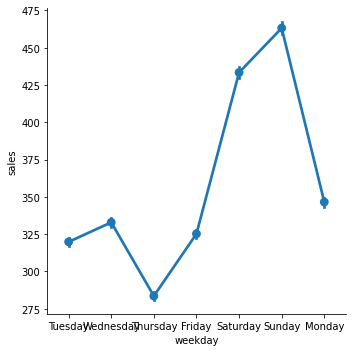

In [31]:
# Sales trend over days
sns.factorplot(data = final_train, x = "weekday", y = "sales")

In [24]:
indexed_final_train = final_train.set_index('date')
indexed_final_train

,id,store_nbr,family,sales,onpromotion,locale,description,dcoilwtico
date,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0,National,Primer dia del ano,NaN
2013-01-01,1,1,BABY CARE,0.000,0,National,Primer dia del ano,NaN
2013-01-01,2,1,BEAUTY,0.000,0,National,Primer dia del ano,NaN
2013-01-01,3,1,BEVERAGES,0.000,0,National,Primer dia del ano,NaN
2013-01-01,4,1,BOOKS,0.000,0,National,Primer dia del ano,NaN
...,...,...,...,...,...,...,...,...
2017-08-15,3000883,9,POULTRY,438.133,0,Local,Fundacion de Riobamba,47.57
2017-08-15,3000884,9,PREPARED FOODS,154.553,1,Local,Fundacion de Riobamba,47.57
2017-08-15,3000885,9,PRODUCE,2419.729,148,Local,Fundacion de Riobamba,47.57


In [32]:
indexed_final_train['date'] = indexed_final_train['date'].dt.weekday_name()

KeyError: ignored

In [28]:
# Sales trend over the months and year
sns.factorplot(data = indexed_final_train, x ="Month", y = "Sales", 
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = "Year")

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


ValueError: ignored

In [30]:
# Sales trend over days
sns.factorplot(data = indexed_final_train, x = "DayOfWeek", y = "Sales", hue = "Promo")

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


ValueError: ignored

In [32]:
indexed_final_train = final_train.set_index('date')

In [26]:
oil_train = final_train["dcoilwtico"].dropna()
oil_train

1782       93.14
1783       93.14
1784       93.14
1785       93.14
1786       93.14
           ...  
3000883    47.57
3000884    47.57
3000885    47.57
3000886    47.57
3000887    47.57
Name: dcoilwtico, Length: 2072466, dtype: float64

In [27]:
# final_train.drop(final_train[final_train['dcoilwtico'] >= 24000].index, inplace = True)

In [ ]:
final_train.loc[final_train["dcoilwtico"] <= 100] = 1
final_train.loc[final_train["dcoilwtico"] > 100] = 0

In [ ]:
oil_final = final_train['dcoilwtico'].loc(final_train['dcoilwtico'] >=100 , 0, inplace=True)
# final_train['dcoilwtico'] >= 100

AttributeError: ignored

In [ ]:
onpromotion_df=final_train.groupby("date")[["onpromotion"]].sum()
onpromotion_df

,onpromotion
date,
2013-01-01,0
2013-01-02,0
2013-01-03,0
2013-01-04,0
2013-01-05,0
...,...
2017-08-11,14179
2017-08-12,8312
2017-08-13,9283


In [ ]:
#Read in the emissions data file 
transactions_file = "resources/transactions.csv"
trans_df = pd.read_csv(transactions_file)
trans_df.head()

In [ ]:
len(trans_df)

In [ ]:
# check data types for SQL compatibility 
trans_df.dtypes

In [ ]:
# convert 'date' column to datetime format for merging with other CSV's 
trans_df['date'] = pd.to_datetime(trans_df['date'])
trans_df.dtypes

In [ ]:
# we are focusing our machine learning models on thirty days from each year included 
april_df = trans_df[((trans_df['date'] >= '2013-04-16') & (trans_df['date'] < '2013-05-16'))
    | ((trans_df['date'] >= '2014-04-16') & (trans_df['date'] < '2014-05-16'))
    | ((trans_df['date'] >= '2015-04-16') & (trans_df['date'] < '2015-05-16'))
    | ((trans_df['date'] >= '2016-04-16') & (trans_df['date'] < '2016-05-16'))
    | ((trans_df['date'] >= '2017-04-16') & (trans_df['date'] < '2017-05-16'))]
april_df.head()

In [ ]:
#checking to make sure the query cut off at desired date 
april_df.tail()

In [ ]:
# printing the number of rows in our datframe for quality assurance during merges 
len(april_df)

In [ ]:
#Read in the stores data file which has location info within Ecuador 
stores_file = "resources/stores.csv"
stores_df = pd.read_csv(stores_file)
stores_df.head()

In [ ]:
# checking that store number type is int64 prior to merge 
stores_df.dtypes

In [ ]:
# performing first merge 
store_april = pd.merge(stores_df, april_df, on ='store_nbr')
store_april.head()

In [ ]:
#checking that number of rows is staying consistent 
len(store_april)

In [ ]:
# read in the holiday data file 
holiday_file = "resources/holidays_events.csv"
holiday_df = pd.read_csv(holiday_file)
holiday_df.tail()

In [ ]:
# checking length of this dataframe before cleaning it 
len(holiday_df)

In [ ]:
# since merge will take place on date column this datatype will need to be converted 
holiday_df.dtypes

In [ ]:
# performing conversion 
holiday_df['date'] = pd.to_datetime(holiday_df['date'])
holiday_df.dtypes

In [ ]:
# excluding rows that cintain  official gvt observance info  
cleaned_hol = holiday_df[holiday_df['transferred'] == False]

In [ ]:
# checking that rows were removed
len(cleaned_hol)

In [ ]:
#removing duplicate rows before merging 
cleaned_hol.drop_duplicates(subset='date', inplace=True)
len(cleaned_hol)

In [ ]:
# performing left join to prevent rows being added during merge 
merged_holiday = pd.merge(store_april, cleaned_hol, on ='date', how="left")
merged_holiday.head()

In [ ]:
# confirming that number of rows is staying consistent 
len(merged_holiday)

In [ ]:
# Read in the oil prices data file 
oil_file = "resources/oil.csv"
oil_df = pd.read_csv(oil_file)
oil_df.head()

In [ ]:
# drop null values from oil dataframe/csv
cleaned_oil=oil_df.dropna()
cleaned_oil.head()

In [ ]:
cleaned_oil['date'] = pd.to_datetime(cleaned_oil['date'])
cleaned_oil.dtypes

In [ ]:
# cleaned_hol.squeeze()
indexed_oil = cleaned_oil.set_index('date', inplace=True)

In [ ]:
cleaned_df = pd.concat([merged_holiday, indexed_oil], axis=1)
len(cleaned_df)

In [ ]:
# cleaned_df = pd.merge(trans_store_hol, cleaned_oil, on ='date')
cleaned_df.head()

In [ ]:
# drop transferred, cluster and type_x column 
final_df = cleaned_df.drop(['type_x', "cluster", "transferred" ], axis=1)
final_df.head()

In [ ]:
final_df.dtypes

In [ ]:
len(final_df)

In [ ]:
#Create SQL Alchemy engine to postgres database "IMDB_db"
protocol = 'postgresql'
username = 'postgres'
password = '0206Teddy'
host = 'localhost'
port = 5432
database_name = 'grocery'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)

In [ ]:
#show the existing table names in the database
engine.table_names()

In [ ]:
#write the data in the dataframe to the database table
final_df.to_sql(name='earthquake_data', con=engine, if_exists='replace', index=False)

In [ ]:
#Query the carbon emissions data table to confirm the above data load
pd.read_sql_query('select * from public."earthquake_data"', con=engine)

In [ ]:
pd.read_sql_query('select * from public."earthquake_data"', con=engine).count()